# AI-based Surveying the Impact of Environmental, Climatic, Economic and Demographic Conditions on the Epidemic Outbreak Rate of COVID-19

$Mehryar{\,}Majd$, $Ramin{\,}Mousa$ \& $Arsalan{\,}Mousazadeh$

__Abstract:__ This study aims to have an analytical and predictive approach to the growth rate and spread of the first wave of COVID-19 infection and mainly focuses on its dependency on other global factors in affected countries via Artificial Intelligence-based processing of fatality data/statistics. Fatality, infected, and recovered cases in the form of the time-series data was acquired through the World Health Organization (WHO) & the Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE). Recorded health data subsequently was analyzed by several Deep Neural Network (DNN) models to create a better intuition of epidemic outbreak rate of COVID-19. Monitoring spreading trend changes becomes more feasible via continuous observation of statistical pattern and integrating the other datasets with more global features count as factors influencing the local conditions on historical data conveys pivotal information concerning learning the pattern of epidemic progression. In this study, attention-based Sequence-to-Sequence (Seq2Seq) models empowered by Long-Short Term Memory (LSTM) and Gated Recurrent Unit (GRU) units, were deployed to predict mortality rate. Ultimately these analyses are utilized to monitor infection behaviour on time-series data and were subsequently assessed for their performance to predict the behaviour of the first wave of COVID-19 outbreak rate intensely. Demographic & environmental conditions have likely been influenced significantly to shape the reliable predictive learning algorithms for long-duration risk of COVID-19 pandemic.

### Used method Analysis COVID-19
__Attention-based Sequence-to-Sequence (Seq2Seq) model__

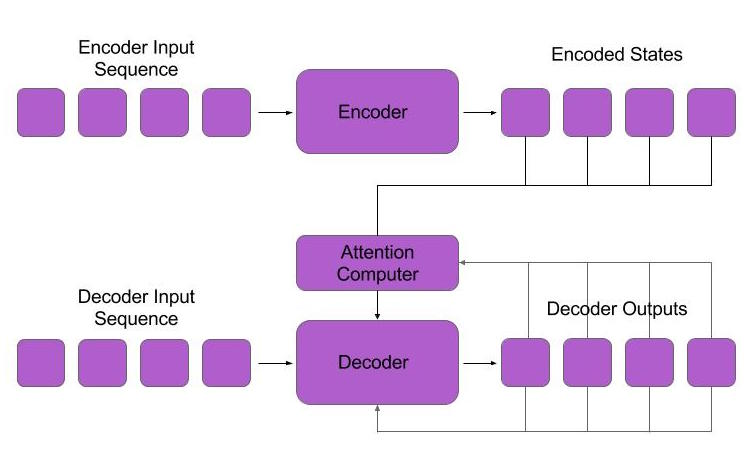

In [20]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from numpy import array

In [21]:
df = pd.read_csv("novel-corona-virus/covid_19_data.csv")
df.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [25]:
df['Last Update'] = pd.to_datetime(df['Last Update'])
df['Day'] = df['Last Update'].apply(lambda x:x.day)
df['Hour'] = df['Last Update'].apply(lambda x:x.hour)
df['Province/State'] = df['Province/State'].astype('category')
df['Country/Region'] = df['Country/Region'].astype('category')
df['Province/State'] = df['Province/State'].cat.codes
df['Country/Region'] = df['Country/Region'].cat.codes
df['Month'] = df['Last Update'].dt.month
df['Week'] = df['Last Update'].dt.week
df.head(2)

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Day,Hour,Month,Week
0,1,01/22/2020,7,94,2020-01-22 17:00:00,1.0,0.0,0.0,22,17,1,4
1,2,01/22/2020,13,94,2020-01-22 17:00:00,14.0,0.0,0.0,22,17,1,4


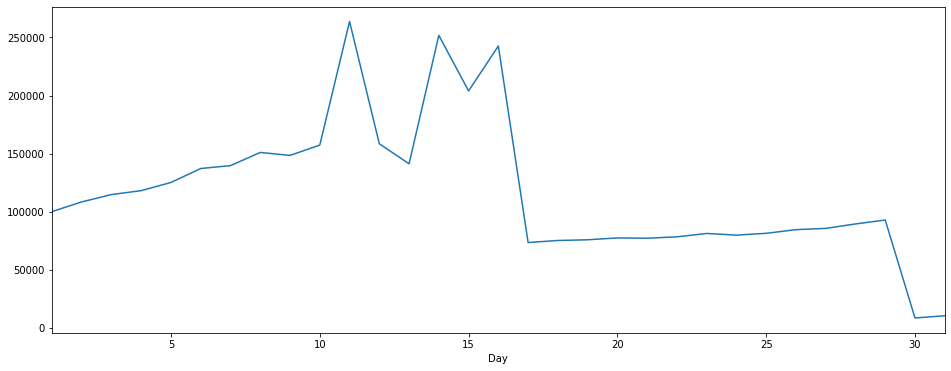

In [23]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(16,6))
df.groupby('Day').sum()['Confirmed'].plot()

In [8]:
Confirmed = df.groupby('Day').sum()['Confirmed']
Deaths = df.groupby('Day').sum()['Deaths']
Recovered = df.groupby('Day').sum()['Recovered']

In [34]:
df = pd.DataFrame(data=[Confirmed, Deaths,Recovered])
df = df.T

In [35]:
from random import randint
from numpy import array
from numpy import argmax
from numpy import array_equal
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM,GRU
from keras.layers import Dense
def load_data(data, time_step=2, after_day=1, validate_percent=0.67):
    seq_length = time_step + after_day
    result = []
    for index in range(len(data) - seq_length + 1):
        result.append(data[index: index + seq_length])
    result = np.array(result)
    print('total data: ', result.shape)
    train_size = int(len(result) * validate_percent)
    train = result[:train_size, :]
    validate = result[train_size:, :]
    x_train = train[:, :time_step]
    y_train = train[:, time_step:]
    x_validate = validate[:, :time_step]
    y_validate = validate[:, time_step:]
    return [x_train, y_train, x_validate, y_validate]

In [46]:
def base_model(feature_len=3, after_day=3, input_shape=(8, 1)):
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=False, input_shape=input_shape))
    #model.add(LSTM(units=100, return_sequences=False, input_shape=input_shape))
    # one to many
    model.add(RepeatVector(after_day))
    #model.add(LSTM(200, return_sequences=True))
    model.add(LSTM(100, return_sequences=True))
    model.add(TimeDistributed(Dense(units=feature_len, activation='linear')))
    return model

def seq2seq(feature_len=1, after_day=1, input_shape=(8, 1)):
    # Encoder
    encoder_inputs = Input(shape=input_shape) # (timesteps, feature)
    encoder = LSTM(units=10, return_state=True,  name='encoder')
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    states = [state_h, state_c]
    # Decoder
    reshapor = Reshape((1, 10), name='reshapor')
    decoder = LSTM(units=10, return_sequences=True, return_state=True, name='decoder')
    # Densor
    #tdensor = TimeDistributed(Dense(units=200, activation='linear', name='time_densor'))
    densor_output = Dense(units=feature_len, activation='linear', name='output')
    inputs = reshapor(encoder_outputs)
    #inputs = tdensor(inputs)
    all_outputs = []
    for _ in range(after_day):
        outputs, h, c = decoder(inputs, initial_state=states)

        #inputs = tdensor(outputs)
        inputs = outputs
        states = [state_h, state_c]

        outputs = densor_output(outputs)
        all_outputs.append(outputs)

    decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
    model = Model(inputs=encoder_inputs, outputs=decoder_outputs)

    return model

In [37]:
def normalize_data(data, scaler, feature_len):
    minmaxscaler = scaler.fit(data)
    normalize_data = minmaxscaler.transform(data)
    return normalize_data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data = normalize_data(df, scaler,df.shape[1])
x_train, y_train, x_validate, y_validate = load_data(data,time_step=2, after_day=4, validate_percent=0.8)
print('train data: ', x_train.shape, y_train.shape)
print('validate data: ', x_validate.shape, y_validate.shape)

total data:  (26, 6, 3)
train data:  (20, 2, 3) (20, 4, 3)
validate data:  (6, 2, 3) (6, 4, 3)


In [38]:
from keras import backend as K
from keras.models import Sequential, load_model, Model
from keras.layers import LSTM, Dense, Activation, TimeDistributed, Dropout, Lambda, RepeatVector, Input, Reshape
from keras.callbacks import ModelCheckpoint

In [48]:
 # model complie
from keras.optimizers import SGD,Adam
# root mean squared error (rmse) for regression (only for Keras tensors)
def rmse(y_true, y_pred):
    from keras import backend
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))
# mean squared error (mse) for regression  (only for Keras tensors)
def mse(y_true, y_pred):
    from keras import backend
    return backend.mean(backend.square(y_pred - y_true), axis=-1)
# coefficient of determination (R^2) for regression  (only for Keras tensors)
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()))
input_shape = (2, data.shape[1])
model = base_model(data.shape[1], 4, input_shape)
model.compile(loss='mse', optimizer='adam',metrics=['acc',rmse,mse,r_square])
from sklearn.datasets import make_moons
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
reduce_lr_acc = ReduceLROnPlateau(monitor='val_acc', factor=0.3, patience=7, verbose=1, min_delta=1e-4, mode='max')
earlyStopping = EarlyStopping(monitor='val_acc', patience=100, verbose=0, mode='max')
history = model.fit(x_train, y_train, batch_size=10,epochs=100,shuffle=False ,validation_data=(x_validate, y_validate))

Train on 20 samples, validate on 6 samples
Epoch 1/100
20/20 [==============================] - 3s 172ms/step - loss: 0.3195 - acc: 0.1000 - rmse: 0.5025 - mse: 0.3195 - r_square: -6.8599 - val_loss: 0.0796 - val_acc: 0.0000e+00 - val_rmse: 0.2666 - val_mse: 0.0796 - val_r_square: -5.2094
Epoch 2/100
20/20 [==============================] - 0s 2ms/step - loss: 0.2915 - acc: 0.1000 - rmse: 0.4747 - mse: 0.2915 - r_square: -6.1863 - val_loss: 0.0706 - val_acc: 0.0000e+00 - val_rmse: 0.2541 - val_mse: 0.0706 - val_r_square: -4.5063
Epoch 3/100
20/20 [==============================] - 0s 2ms/step - loss: 0.2645 - acc: 0.1000 - rmse: 0.4458 - mse: 0.2645 - r_square: -5.5295 - val_loss: 0.0615 - val_acc: 0.0000e+00 - val_rmse: 0.2402 - val_mse: 0.0615 - val_r_square: -3.7989
Epoch 4/100
20/20 [==============================] - 0s 2ms/step - loss: 0.2361 - acc: 0.1000 - rmse: 0.4149 - mse: 0.2361 - r_square: -4.8362 - val_loss: 0.0521 - val_acc: 0.0000e+00 - val_rmse: 0.2238 - val_mse: 0.0521

Epoch 68/100
20/20 [==============================] - 0s 3ms/step - loss: 0.0570 - acc: 0.5125 - rmse: 0.1891 - mse: 0.0570 - r_square: -0.0741 - val_loss: 0.0219 - val_acc: 0.8333 - val_rmse: 0.0986 - val_mse: 0.0219 - val_r_square: -0.7104
Epoch 69/100
20/20 [==============================] - 0s 3ms/step - loss: 0.0569 - acc: 0.5125 - rmse: 0.1889 - mse: 0.0569 - r_square: -0.0715 - val_loss: 0.0220 - val_acc: 0.8333 - val_rmse: 0.0987 - val_mse: 0.0220 - val_r_square: -0.7147
Epoch 70/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0568 - acc: 0.5125 - rmse: 0.1887 - mse: 0.0568 - r_square: -0.0688 - val_loss: 0.0220 - val_acc: 0.8333 - val_rmse: 0.0989 - val_mse: 0.0220 - val_r_square: -0.7194
Epoch 71/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0567 - acc: 0.5125 - rmse: 0.1885 - mse: 0.0567 - r_square: -0.0661 - val_loss: 0.0221 - val_acc: 0.8333 - val_rmse: 0.0991 - val_mse: 0.0221 - val_r_square: -0.7242
Epoch 72/100
20/20 [============

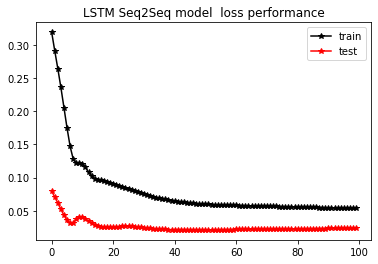

In [49]:
plt.plot(history.history['loss'],'k-*',label='train')
plt.plot(history.history['val_loss'],'r-*', label='test')
plt.legend()
plt.title("LSTM Seq2Seq model  loss performance")
plt.savefig("LSTMLOSS.pdf", bbox_inches='tight')
plt.show()

In [32]:
import math 
print('-' * 100)
train_score = model.evaluate(x=x_train, y=y_train, batch_size=3, verbose=0)
print('Train Score: %.8f MSE (%.8f RMSE ) , %.8f  ACC' % (train_score[0], math.sqrt(train_score[0]),train_score[1]*100)  )


validate_score = model.evaluate(x=x_validate, y=y_validate, batch_size=3, verbose=0)
print('Validation Score: %.8f MSE (%.8f RMSE ) , %.8f  ACC' % (validate_score[0], math.sqrt(validate_score[0]),validate_score[1]*100))
train_predict = model.predict(x_train)
validate_predict = model.predict(x_validate)

def inverse_normalize_data(data, scaler):
    for i in range(len(data)):
        data[i] = scaler.inverse_transform(data[i])

    return data

train_predict= inverse_normalize_data(train_predict, scaler)
y_train = inverse_normalize_data(y_train, scaler)
validate_predict = inverse_normalize_data(validate_predict, scaler)
y_validate= inverse_normalize_data(y_validate, scaler)

----------------------------------------------------------------------------------------------------
Train Score: 0.05268562 MSE (0.22953348 RMSE ) , 57.50000082  ACC
Validation Score: 0.02488241 MSE (0.15774159 RMSE ) , 83.33333433  ACC


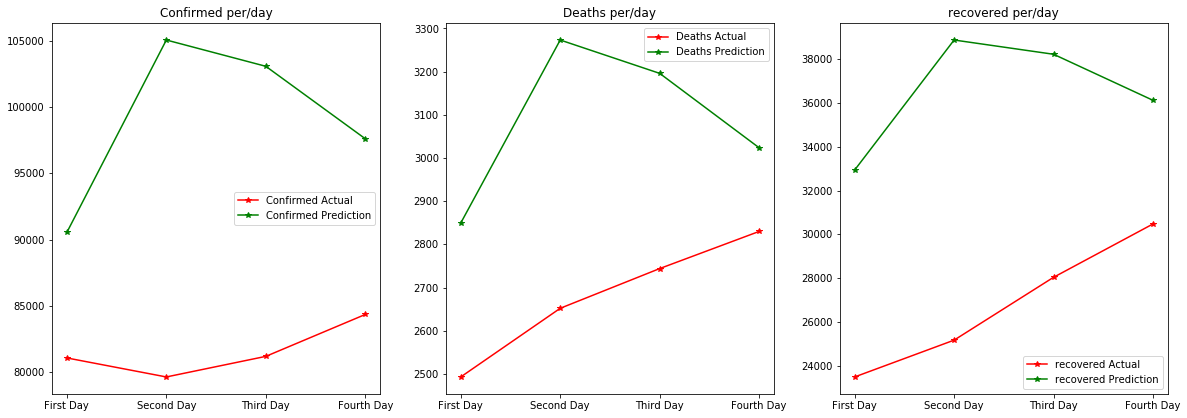

In [33]:

#test_predict = inverse_normalize_data(test_predict, scaler)
day = ['First Day','Second Day','Third Day','Fourth Day']
#dfx = pd.DataFrame(data=[y_validate[:], validate_predict])
#dfx = dfx.T
#dfx
fig = plt.figure(figsize=(20, 15))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax1.plot(day,y_validate[:,:,0][0],'r-*',label='Confirmed Actual')
ax1.plot(day,validate_predict[:,:,0][0],'g-*',label='Confirmed Prediction')
ax1.title.set_text("Confirmed per/day")
ax1.legend()
ax2.plot(day,y_validate[:,:,1][0],'r-*',label='Deaths Actual')
ax2.plot(day,validate_predict[:,:,1][0],'g-*',label='Deaths Prediction')
ax2.title.set_text("Deaths per/day")
ax2.legend()
ax3.plot(day,y_validate[:,:,2][0],'r-*',label='recovered Actual')
ax3.plot(day,validate_predict[:,:,2][0],'g-*',label='recovered Prediction')
ax3.title.set_text("recovered per/day")
ax3.legend()
plt.savefig("LSTM_PREDICTIO.pdf", bbox_inches='tight')
plt.show()

# GRU Model

In [50]:
def base_model2(feature_len=3, after_day=3, input_shape=(8, 1)):
    model = Sequential()
    model.add(GRU(units=10, return_sequences=False, input_shape=input_shape))
    #model.add(LSTM(units=100, return_sequences=False, input_shape=input_shape))
    # one to many
    model.add(RepeatVector(after_day))
    #model.add(LSTM(200, return_sequences=True))
    model.add(GRU(10, return_sequences=True))
    model.add(TimeDistributed(Dense(units=feature_len, activation='linear')))
    return model
opt = Adam(lr=0.01)
input_shape = (2, data.shape[1])
model = base_model2(data.shape[1], 4, input_shape)
model.compile(loss='mse', optimizer=opt,metrics=['acc',mse,rmse,r_square])
model.summary()
history = model.fit(x_train, y_train, batch_size=10, epochs=100,shuffle=False ,validation_data=(x_validate, y_validate))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_9 (GRU)                  (None, 10)                420       
_________________________________________________________________
repeat_vector_9 (RepeatVecto (None, 4, 10)             0         
_________________________________________________________________
gru_10 (GRU)                 (None, 4, 10)             630       
_________________________________________________________________
time_distributed_9 (TimeDist (None, 4, 3)              33        
Total params: 1,083
Trainable params: 1,083
Non-trainable params: 0
_________________________________________________________________
Train on 20 samples, validate on 6 samples
Epoch 1/100
20/20 [==============================] - 4s 199ms/step - loss: 0.3802 - acc: 0.3875 - mse: 0.3802 - rmse: 0.5441 - r_square: -8.6683 - val_loss: 0.0511 - val_acc: 0.1667 - val_mse: 0.0511 - val_rmse: 0.2209 - val_r_sq

20/20 [==============================] - 0s 935us/step - loss: 0.0556 - acc: 0.5125 - mse: 0.0556 - rmse: 0.1912 - r_square: -0.0268 - val_loss: 0.0291 - val_acc: 0.8333 - val_mse: 0.0291 - val_rmse: 0.1277 - val_r_square: -1.2674
Epoch 32/100
20/20 [==============================] - 0s 917us/step - loss: 0.0553 - acc: 0.5125 - mse: 0.0553 - rmse: 0.1910 - r_square: -0.0218 - val_loss: 0.0292 - val_acc: 0.8333 - val_mse: 0.0292 - val_rmse: 0.1288 - val_r_square: -1.2803
Epoch 33/100
20/20 [==============================] - 0s 863us/step - loss: 0.0550 - acc: 0.5125 - mse: 0.0550 - rmse: 0.1903 - r_square: -0.0152 - val_loss: 0.0293 - val_acc: 0.8333 - val_mse: 0.0293 - val_rmse: 0.1292 - val_r_square: -1.2815
Epoch 34/100
20/20 [==============================] - 0s 1ms/step - loss: 0.0546 - acc: 0.5125 - mse: 0.0546 - rmse: 0.1892 - r_square: -0.0077 - val_loss: 0.0291 - val_acc: 0.8333 - val_mse: 0.0291 - val_rmse: 0.1287 - val_r_square: -1.2674
Epoch 35/100
20/20 [===================

Epoch 65/100
20/20 [==============================] - 0s 978us/step - loss: 0.0460 - acc: 0.5125 - mse: 0.0460 - rmse: 0.1623 - r_square: 0.1456 - val_loss: 0.0267 - val_acc: 0.8333 - val_mse: 0.0267 - val_rmse: 0.1141 - val_r_square: -1.0788
Epoch 66/100
20/20 [==============================] - 0s 914us/step - loss: 0.0456 - acc: 0.5125 - mse: 0.0456 - rmse: 0.1613 - r_square: 0.1519 - val_loss: 0.0267 - val_acc: 0.8333 - val_mse: 0.0267 - val_rmse: 0.1142 - val_r_square: -1.0857
Epoch 67/100
20/20 [==============================] - 0s 1ms/step - loss: 0.0452 - acc: 0.5125 - mse: 0.0452 - rmse: 0.1603 - r_square: 0.1579 - val_loss: 0.0268 - val_acc: 0.8333 - val_mse: 0.0268 - val_rmse: 0.1142 - val_r_square: -1.0923
Epoch 68/100
20/20 [==============================] - 0s 926us/step - loss: 0.0449 - acc: 0.5125 - mse: 0.0449 - rmse: 0.1594 - r_square: 0.1636 - val_loss: 0.0270 - val_acc: 0.8333 - val_mse: 0.0270 - val_rmse: 0.1143 - val_r_square: -1.1020
Epoch 69/100
20/20 [==========

Epoch 99/100
20/20 [==============================] - 0s 1ms/step - loss: 0.0369 - acc: 0.5875 - mse: 0.0369 - rmse: 0.1399 - r_square: 0.2629 - val_loss: 0.0275 - val_acc: 0.8333 - val_mse: 0.0275 - val_rmse: 0.1027 - val_r_square: -1.1439
Epoch 100/100
20/20 [==============================] - 0s 1ms/step - loss: 0.0368 - acc: 0.5875 - mse: 0.0368 - rmse: 0.1396 - r_square: 0.2630 - val_loss: 0.0274 - val_acc: 0.8333 - val_mse: 0.0274 - val_rmse: 0.1022 - val_r_square: -1.1404


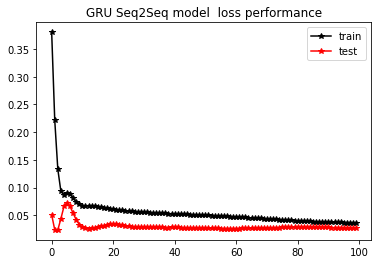

In [51]:
plt.plot(history.history['loss'],'k-*',label='train')
plt.plot(history.history['val_loss'],'r-*', label='test')
plt.legend()
plt.title("GRU Seq2Seq model  loss performance")
plt.savefig("GRULOSS.pdf", bbox_inches='tight')
plt.show()

----------------------------------------------------------------------------------------------------
Train Score: 0.03549420 MSE (0.18839904 RMSE ) , 67.50000030  ACC
Validation Score: 0.02587636 MSE (0.16086129 RMSE ) , 83.33333433  ACC


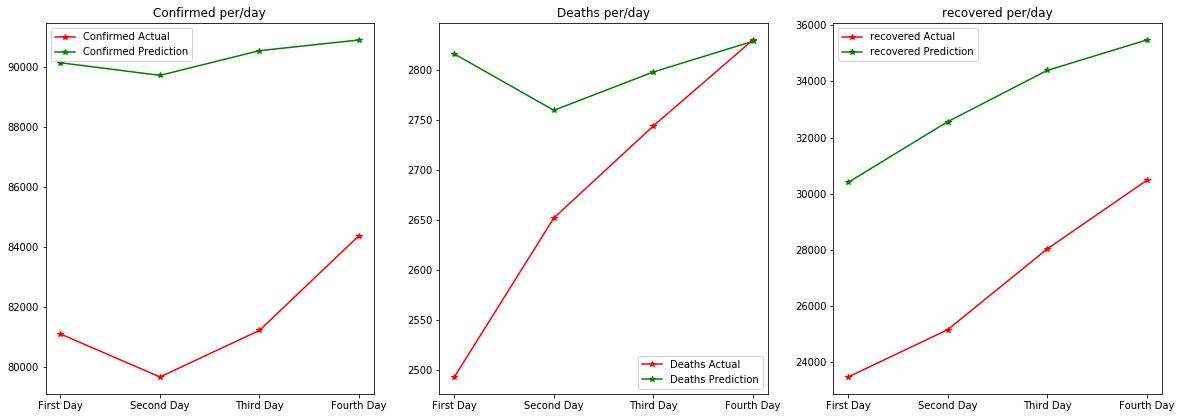

In [44]:
import math 
print('-' * 100)
train_score = model.evaluate(x=x_train, y=y_train, batch_size=3, verbose=0)
print('Train Score: %.8f MSE (%.8f RMSE ) , %.8f  ACC' % (train_score[0], math.sqrt(train_score[0]),train_score[1]*100)  )


validate_score = model.evaluate(x=x_validate, y=y_validate, batch_size=3, verbose=0)
print('Validation Score: %.8f MSE (%.8f RMSE ) , %.8f  ACC' % (validate_score[0], math.sqrt(validate_score[0]),validate_score[1]*100))
train_predict = model.predict(x_train)
validate_predict = model.predict(x_validate)

def inverse_normalize_data(data, scaler):
    for i in range(len(data)):
        data[i] = scaler.inverse_transform(data[i])

    return data

train_predict= inverse_normalize_data(train_predict, scaler)
y_train = inverse_normalize_data(y_train, scaler)
validate_predict = inverse_normalize_data(validate_predict, scaler)
y_validate= inverse_normalize_data(y_validate, scaler)
#test_predict = inverse_normalize_data(test_predict, scaler)
day = ['First Day','Second Day','Third Day','Fourth Day']
#dfx = pd.DataFrame(data=[y_validate[:], validate_predict])
#dfx = dfx.T
#dfx
fig = plt.figure(figsize=(20, 15))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)

ax1.plot(day,y_validate[:,:,0][0],'r-*',label='Confirmed Actual')
ax1.plot(day,validate_predict[:,:,0][0],'g-*',label='Confirmed Prediction')
ax1.title.set_text("Confirmed per/day")
ax1.legend()
ax2.plot(day,y_validate[:,:,1][0],'r-*',label='Deaths Actual')
ax2.plot(day,validate_predict[:,:,1][0],'g-*',label='Deaths Prediction')
ax2.title.set_text("Deaths per/day")
ax2.legend()
ax3.plot(day,y_validate[:,:,2][0],'r-*',label='recovered Actual')
ax3.plot(day,validate_predict[:,:,2][0],'g-*',label='recovered Prediction')
ax3.title.set_text("recovered per/day")
ax3.legend()
plt.savefig("GRU_PREDICTIO.pdf", bbox_inches='tight')
plt.show()

# Seq2Seq model

In [52]:
opt = Adam(lr=0.01)
input_shape = (2, data.shape[1])
model = seq2seq(data.shape[1], 4, input_shape)
model.compile(loss='mse', optimizer=opt,metrics=['acc',mse,rmse,r_square])
history = model.fit(x_train, y_train, batch_size=10, epochs=100,shuffle=False ,validation_data=(x_validate, y_validate))

Train on 20 samples, validate on 6 samples
Epoch 1/100
20/20 [==============================] - 6s 310ms/step - loss: 0.3384 - acc: 0.6625 - mse: 0.3384 - rmse: 0.5187 - r_square: -7.3822 - val_loss: 0.0716 - val_acc: 0.1667 - val_mse: 0.0716 - val_rmse: 0.2536 - val_r_square: -4.5837
Epoch 2/100
20/20 [==============================] - 0s 2ms/step - loss: 0.2745 - acc: 0.3875 - mse: 0.2745 - rmse: 0.4557 - r_square: -5.8402 - val_loss: 0.0503 - val_acc: 0.1667 - val_mse: 0.0503 - val_rmse: 0.2176 - val_r_square: -2.9251
Epoch 3/100
20/20 [==============================] - 0s 2ms/step - loss: 0.2167 - acc: 0.3875 - mse: 0.2167 - rmse: 0.3899 - r_square: -4.4534 - val_loss: 0.0326 - val_acc: 0.1667 - val_mse: 0.0326 - val_rmse: 0.1782 - val_r_square: -1.5443
Epoch 4/100
20/20 [==============================] - 0s 2ms/step - loss: 0.1629 - acc: 0.3875 - mse: 0.1629 - rmse: 0.3330 - r_square: -3.1263 - val_loss: 0.0204 - val_acc: 0.1667 - val_mse: 0.0204 - val_rmse: 0.1362 - val_r_square:

Epoch 35/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0535 - acc: 0.5125 - mse: 0.0535 - rmse: 0.1846 - r_square: 0.0248 - val_loss: 0.0281 - val_acc: 0.8333 - val_mse: 0.0281 - val_rmse: 0.1236 - val_r_square: -1.1925
Epoch 36/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0531 - acc: 0.5125 - mse: 0.0531 - rmse: 0.1843 - r_square: 0.0262 - val_loss: 0.0274 - val_acc: 0.8333 - val_mse: 0.0274 - val_rmse: 0.1206 - val_r_square: -1.1350
Epoch 37/100
20/20 [==============================] - 0s 1ms/step - loss: 0.0528 - acc: 0.5125 - mse: 0.0528 - rmse: 0.1839 - r_square: 0.0265 - val_loss: 0.0266 - val_acc: 0.8333 - val_mse: 0.0266 - val_rmse: 0.1175 - val_r_square: -1.0783
Epoch 38/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0525 - acc: 0.5125 - mse: 0.0525 - rmse: 0.1832 - r_square: 0.0272 - val_loss: 0.0260 - val_acc: 0.8333 - val_mse: 0.0260 - val_rmse: 0.1148 - val_r_square: -1.0302
Epoch 39/100
20/20 [================

Epoch 69/100
20/20 [==============================] - 0s 1ms/step - loss: 0.0365 - acc: 0.5125 - mse: 0.0365 - rmse: 0.1373 - r_square: 0.3001 - val_loss: 0.0185 - val_acc: 0.8333 - val_mse: 0.0185 - val_rmse: 0.0728 - val_r_square: -0.4393
Epoch 70/100
20/20 [==============================] - ETA: 0s - loss: 0.0262 - acc: 0.8250 - mse: 0.0262 - rmse: 0.1176 - r_square: 0.205 - 0s 2ms/step - loss: 0.0363 - acc: 0.5125 - mse: 0.0363 - rmse: 0.1369 - r_square: 0.3025 - val_loss: 0.0186 - val_acc: 0.8333 - val_mse: 0.0186 - val_rmse: 0.0731 - val_r_square: -0.4482
Epoch 71/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0360 - acc: 0.5125 - mse: 0.0360 - rmse: 0.1364 - r_square: 0.3040 - val_loss: 0.0187 - val_acc: 0.8333 - val_mse: 0.0187 - val_rmse: 0.0733 - val_r_square: -0.4594
Epoch 72/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0358 - acc: 0.5125 - mse: 0.0358 - rmse: 0.1361 - r_square: 0.3051 - val_loss: 0.0189 - val_acc: 0.8333 - val_mse: 

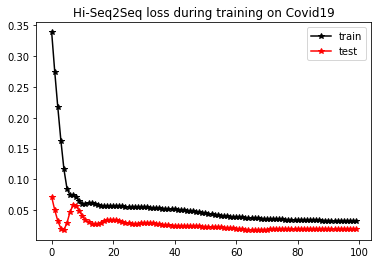

In [53]:
plt.plot(history.history['loss'],'k-*',label='train')
plt.plot(history.history['val_loss'],'r-*', label='test')
plt.legend()
plt.title("Hi-Seq2Seq loss during training on Covid19")
plt.savefig("Seq2SeqLOSS.pdf", bbox_inches='tight')
plt.show()

----------------------------------------------------------------------------------------------------
Train Score: 0.03127815 MSE (0.17685631 RMSE ) , 80.00000045  ACC
Validation Score: 0.02129477 MSE (0.14592727 RMSE ) , 75.00000000  ACC


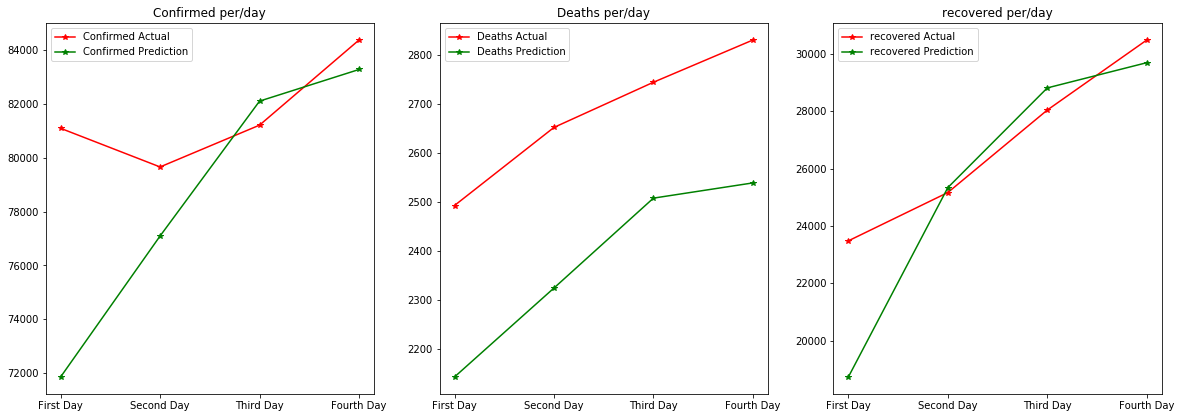

In [55]:
import math 
print('-' * 100)
train_score = model.evaluate(x=x_train, y=y_train, batch_size=3, verbose=0)
print('Train Score: %.8f MSE (%.8f RMSE ) , %.8f  ACC' % (train_score[0], math.sqrt(train_score[0]),train_score[1]*100)  )


validate_score = model.evaluate(x=x_validate, y=y_validate, batch_size=3, verbose=0)
print('Validation Score: %.8f MSE (%.8f RMSE ) , %.8f  ACC' % (validate_score[0], math.sqrt(validate_score[0]),validate_score[1]*100))
train_predict = model.predict(x_train)
validate_predict = model.predict(x_validate)
        #test_predict = model.predict(x_test)

def inverse_normalize_data(data, scaler):
    for i in range(len(data)):
        data[i] = scaler.inverse_transform(data[i])

    return data
train_predict = inverse_normalize_data(train_predict, scaler)
y_train = inverse_normalize_data(y_train, scaler)
validate_predict = inverse_normalize_data(validate_predict, scaler)
y_validate = inverse_normalize_data(y_validate, scaler)
#test_predict = inverse_normalize_data(test_predict, scaler)
day = ['First Day','Second Day','Third Day','Fourth Day']
#dfx = pd.DataFrame(data=[y_validate[:], validate_predict])
#dfx = dfx.T
#dfx
fig = plt.figure(figsize=(20, 15))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax1.plot(day,y_validate[:,:,0][0],'r-*',label='Confirmed Actual')
ax1.plot(day,validate_predict[:,:,0][0],'g-*',label='Confirmed Prediction')
ax1.title.set_text("Confirmed per/day")
ax1.legend()
ax2.plot(day,y_validate[:,:,1][0],'r-*',label='Deaths Actual')
ax2.plot(day,validate_predict[:,:,1][0],'g-*',label='Deaths Prediction')
ax2.title.set_text("Deaths per/day")
ax2.legend()
ax3.plot(day,y_validate[:,:,2][0],'r-*',label='recovered Actual')
ax3.plot(day,validate_predict[:,:,2][0],'g-*',label='recovered Prediction')
ax3.title.set_text("recovered per/day")
ax3.legend()
plt.savefig("Seq2Seq_PREDICTIO.pdf", bbox_inches='tight')
plt.show()